In [1]:
using Plots

In [2]:
include("../src/SpinonStructure.jl")
include("../src/BZMath.jl")


using .BZmath
using .SpinonStructure
using StaticArrays
using SparseArrays
using LinearAlgebra
using BenchmarkTools

In [3]:
const integration_settings = Dict(
    "very_fast" => IntegrationParameters(n_K_samples=10,   broadening_dE=0.1),
    "fast" =>   IntegrationParameters(n_K_samples=100,  broadening_dE=0.05),
    "slow" =>      IntegrationParameters(n_K_samples=1000, broadening_dE=0.02),
    "very_slow" => IntegrationParameters(n_K_samples=10000,broadening_dE=0.02),
    "ultra_slow" => IntegrationParameters(n_K_samples=100000,broadening_dE=0.02)
)

Dict{String, IntegrationParameters} with 5 entries:
  "slow"       => IntegrationParameters(1000, 0.02)
  "fast"       => IntegrationParameters(100, 0.05)
  "very_slow"  => IntegrationParameters(10000, 0.02)
  "ultra_slow" => IntegrationParameters(100000, 0.02)
  "very_fast"  => IntegrationParameters(10, 0.1)

# Gauge freedom

Here, I construct two sim bodies with the same flux pattern (see assertion), but different gauges.

Though the spinon spectrum may depend nontrivially on gauge, the continuum should not.

In [4]:
sim0 = SimulationParameters("0flux_prim",
    lattice=geom.PyroPrimitive(1,1,1),
    A=zeros(1,4),
    Jpm=-0.046,
    B=[0.,0.,0.],
    n_samples=10000
    )

sim1 = SimulationParameters("0flux_std_gauge",
    lattice=geom.PyroPrimitive(2,2,1),
    A=zeros(4,4),
    Jpm=-0.046,
    B=[0.,0.,0.],
    n_samples=10000
    )

sim2 = SimulationParameters("0flux_gauge_2",
    lattice=geom.PyroPrimitive(2,2,1),
    # A=[1 1 0 0; 0 0 -1 -1; 1 1 0 0; 1 1 0 0],
    A=[2 2 2 2; -1 -1 -1 -1; 0 0 0 0; 1 1 1 1],
    Jpm=-0.046,
    B=[0.,0.,0.],
    n_samples=10000
    )

# large gauge t'form
sim3 = SimulationParameters("0flux_gauge_3",
    lattice=geom.PyroPrimitive(2,2,1),
    A=[1 1 0 0; 1 1 0 0; 1 1 0 0; 1 1 0 0],
    Jpm=-0.046,
    B=[0.,0.,0.],
    n_samples=10000
    )


sim222 = SimulationParameters("0flux_222",
    lattice=geom.PyroPrimitive(2,2,2),
    # A=[1 1 0 0; 0 0 -1 -1; 1 1 0 0; 1 1 0 0],
    A=zeros(2*2*2, 4),
    Jpm=-0.046,
    B=[0.,0.,0.],
    n_samples=10000
    )

@assert norm(calc_fluxes(sim2) - calc_fluxes(sim1)) < 1e-10
@assert norm(calc_fluxes(sim3) - calc_fluxes(sim1)) < 1e-10

In [5]:
csim0 = CompiledModel(sim0)

CompiledModel(SimulationParameters([0.0 0.0 0.0 0.0], -0.046, [0.0, 0.0, 0.0], Main.SpinonStructure.PyrochloreGeometry.PyroPrimitive([1, 1, 1], SVector{3, Int64}[[0, 0, 0], [2, 2, 2]], SVector{3, Int64}[[1, 1, 1], [1, -1, -1], [-1, 1, -1], [-1, -1, 1]]), 2.0, 10000, "0flux_prim"), [2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2], ComplexF64[-0.0115 - 0.0im, -0.0115 - 0.0im, -0.0115 - 0.0im, -0.0115 - 0.0im, -0.0115 - 0.0im, -0.0115 - 0.0im, -0.0115 - 0.0im, -0.0115 - 0.0im, -0.0115 - 0.0im, -0.0115 - 0.0im, -0.0115 - 0.0im, -0.0115 - 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], [0.0 4.0 … -2.0 -2.0; 4.0 0.0 … 2.0 -2.0; 4.0 4.0 … -2.0 2.0], 0.14177420069268665)

In [6]:
# csim222 = CompiledModel(sim222)

In [7]:
csim1 = CompiledModel(sim1)
csim2 = CompiledModel(sim2)
csim3 = CompiledModel(sim3)
@assert norm(csim1.lambda - csim2.lambda) < 1e-3
@assert norm(csim1.lambda - csim3.lambda) < 1e-3
println("simi.λ -> $(csim1.lambda)  sim2.λ -> $(csim2.lambda)")

simi.λ -> 0.14144406859024206  sim2.λ -> 0.1410359031921725


In [8]:
"""
global_g must be a row vector
"""
function global_gauge(A_original, global_g)
    return A_original .+ global_g
end

"""
lattice_gradient(lat::geom.PyroPrimitive, G::Vector{Float64})
Calculates the lattice gradient of G, [dG]_{rA,μ}
where rA is an A site position, μ is a sublattice
"""
function lattice_gradient(lat::geom.PyroPrimitive, G::Vector{Float64})
    A_sites = geom.A_sites(lat)
    @assert size(G) == size(lat.tetra_sites)
    retval = zeros(length(A_sites),4)
    for (i,rA) in enumerate(A_sites)
        for μ=1:4
            retval[i,μ] = G[i] - G[geom.tetra_idx(lat, rA + 2 .*geom.pyro[μ])]
        end
    end
    return retval
end

lat = geom.PyroPrimitive(2,2,1)
gaugevec = 2π .*rand(Float64, size(lat.tetra_sites)).-π

sim_test = SimulationParameters("0flux_random",
    lattice=lat,
    # A=[1 1 0 0; 0 0 -1 -1; 1 1 0 0; 1 1 0 0],
    A=lattice_gradient(lat, gaugevec),
    Jpm=-0.046,
    B=[0.,0.,0.],
    n_samples=10000
    )
@assert norm(calc_fluxes(sim1)-calc_fluxes(sim_test)) < 1e-14

In [9]:
Egrid = collect(range(0,2.2,100));
ip = integration_settings["slow"]
Q = SVector{3}(geom.high_symmetry_points["\\Gamma"])


3-element SVector{3, Float64} with indices SOneTo(3):
 0.0
 0.0
 0.0

In [10]:
gaugevec = 2π .*rand(Float64, size(lat.tetra_sites)).-π

    sim_test = SimulationParameters("0flux_random",
    lattice=lat,
    # A=[1 1 0 0; 0 0 -1 -1; 1 1 0 0; 1 1 0 0],
    A=lattice_gradient(lat, gaugevec),
    Jpm=-0.046,
    B=[0.,0.,0.],
    n_samples=10000
    )

@assert norm(calc_fluxes(sim1)-calc_fluxes(sim_test)) < 1e-14



ch_test = SpinonStructure.CompiledHamiltonian(sim_test);

In [11]:
H1 = SpinonStructure.calc_hopping(csim1, Q)
H2 = SpinonStructure.calc_hopping(ch_test, Q)

8×8 SparseMatrixCSC{ComplexF64, Int64} with 32 stored entries:
     -0.023+0.0im        -0.0239778-0.0392564im   …             ⋅    
 -0.0239778+0.0392564im      -0.023+0.0im                       ⋅    
 0.00917958+0.0450748im  -0.0168409+0.0156647im                 ⋅    
 -0.0110078+0.0201948im  -0.0459442+0.00226516im                ⋅    
            ⋅                       ⋅                -0.0122807+0.0194469im
            ⋅                       ⋅             …    0.045831-0.00393995im
            ⋅                       ⋅                -0.0433998+0.0152465im
            ⋅                       ⋅                    -0.023+0.0im

In [12]:
gauge = diagm(exp.(-1im.*gaugevec))
diff = gauge'*H2*gauge  - H1

display(norm.(diff) .> 1e-15)
@assert norm(diff) < 1e-14
println("gauge transform behaves correctly")

8×8 BitMatrix:
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0

gauge transform behaves correctly


In [13]:
ev1 = SpinonStructure.diagonalise_M(csim1, Q);
ev2 = SpinonStructure.diagonalise_M(ch_test, Q);
# ev3 = SpinonStructure.diagonalise_M(csim3, Q+shift);

In [14]:
@assert norm(ev1.values - ev2.values) < 1e-10

# diff = (ev1.vectors - ev2.vectors)

# findall( abs.(diff) .> 1e-10 )

In [15]:
gauge'*ev2.vectors

8×8 Matrix{ComplexF64}:
 -0.342359-0.364404im        0.0+0.0im       …        0.0+0.0im
 -0.342359-0.364404im        0.0+0.0im                0.0+0.0im
 -0.342359-0.364404im        0.0+0.0im                0.0+0.0im
 -0.342359-0.364404im        0.0+0.0im                0.0+0.0im
       0.0+0.0im       -0.497207+0.052776im     -0.497207+0.052776im
       0.0+0.0im       -0.497207+0.052776im  …   0.497207-0.052776im
       0.0+0.0im       -0.497207+0.052776im      0.497207-0.052776im
       0.0+0.0im       -0.497207+0.052776im     -0.497207+0.052776im

In [16]:
path = generate_path(geom.high_symmetry_points, split("\\Gamma X W K \\Gamma L U W"), points_per_unit=150, K_units=2π/8);

function plot_spinons(f;color=:black)
    E = reduce(vcat, map(f, path.K )')

    plot!(path.t,E,legend=false,color=color,lw=0.5)
    xticks!(path.ticks_t, path.ticks_label)
    ylims!(0.,maximum(E))
end


plot_spinons (generic function with 1 method)

In [17]:
A4 = repeat(rand(4)',4)*2π

# large gauge t'form
sim4 = SimulationParameters("0flux_gauge_3",
    lattice=geom.PyroPrimitive(2,2,1),
    A=A4,
    Jpm=-0.046,
    B=[0.,0.,0.],
    n_samples=10000
    )

csim4 = CompiledModel(sim4)

CompiledModel(SimulationParameters([0.32024699315755073 2.2522237128273317 1.0451404035964944 3.8181799876462055; 0.32024699315755073 2.2522237128273317 1.0451404035964944 3.8181799876462055; 0.32024699315755073 2.2522237128273317 1.0451404035964944 3.8181799876462055; 0.32024699315755073 2.2522237128273317 1.0451404035964944 3.8181799876462055], -0.046, [0.0, 0.0, 0.0], Main.SpinonStructure.PyrochloreGeometry.PyroPrimitive([2, 2, 1], SVector{3, Int64}[[0, 0, 0], [4, 0, 4], [0, 4, 4], [4, 4, 8], [2, 2, 2], [6, 2, 6], [2, 6, 6], [6, 6, 10]], SVector{3, Int64}[[1, 1, 1], [1, -1, -1], [-1, 1, -1], [-1, -1, 1], [5, 1, 5], [5, -1, 3], [3, 1, 3], [3, -1, 5], [1, 5, 5], [1, 3, 3], [-1, 5, 3], [-1, 3, 5], [5, 5, 9], [5, 3, 7], [3, 5, 7], [3, 3, 9]]), 2.0, 10000, "0flux_gauge_3"), [5, 5, 5, 7, 7, 6, 1, 1, 1, 3  …  2, 2, 3, 3, 3, 3, 4, 4, 4, 4], [7, 6, 5, 6, 5, 5, 3, 2, 1, 2  …  5, 6, 7, 5, 8, 7, 8, 6, 7, 8], ComplexF64[0.004063855205758461 + 0.010758024022404387im, -0.008608556161842808 + 0.007

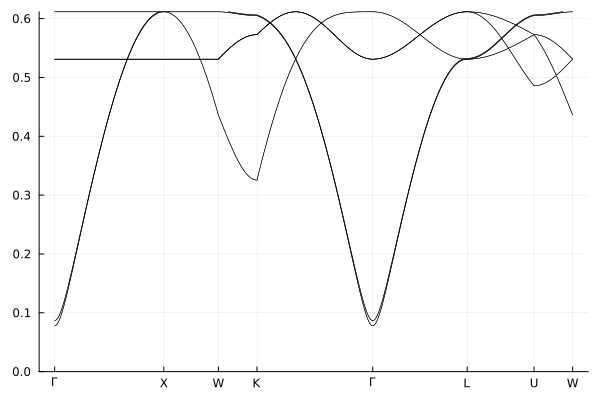

In [26]:
shift3 = reduce(hcat, geom.pyro)*sim3.A[1,:]/8
shift4 = reduce(hcat, geom.pyro)*sim4.A[1,:]/8
plot()
plot_spinons(k -> spinon_dispersion(k,csim0)[1] )
plot_spinons(k -> spinon_dispersion(k,csim2)[1] )
# plot_spinons(k -> spinon_dispersion(k+shift3,csim3)[1],color=:red )
# plot_spinons(k -> spinon_dispersion(k+shift4,csim4)[1],color=:green )
# plot_spinons(k -> spinon_dispersion(k,csim222)[1],color=:green )

In [27]:
csim = csim1

Q = SVector{3}([0.,0.,0])
P = SVector{3}([0.,0,0])
delta = [1,0,0]

E1, S1 = corr_at(Q, P, csim)
E2, S2 = corr_at(Q+ geom.primitive_recip_basis*delta, P,csim)
@assert norm(E1 - E2) < 1e-9
        # @assert norm(S1 - S2) < 1e-10 

norm.(S1 - S2)

8×8 Matrix{Float64}:
 0.0  435.531        4.44089e-16  0.0  0.0  1.33227e-15  0.0  2.22045e-16
 0.0    0.0          0.0          0.0  0.0  0.0          0.0  0.0
 0.0    0.0          0.0          0.0  0.0  0.0          0.0  0.0
 0.0    4.44089e-16  8.88178e-16  0.0  0.0  3.53497      0.0  5.55112e-17
 0.0    8.88178e-16  3.53497      0.0  0.0  8.88178e-16  0.0  0.0
 0.0    0.0          0.0          0.0  0.0  0.0          0.0  0.0
 0.0    2.22045e-16  5.55112e-17  0.0  0.0  8.68524e-34  0.0  2.66746
 0.0    0.0          0.0          0.0  0.0  0.0          0.0  0.0

In [20]:
b = geom.primitive_recip_basis

mats = [SpinonStructure.calc_hopping(csim1, Q+b*n) for n in [[1,0,0],[1,1,0],[0,-1,-1],[-5,1,6]]]
[norm(SpinonStructure.calc_hopping(csim1, Q)-M) for M in mats]

4-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0

In [21]:
ip = integration_settings["very_slow"]
Q = SVector{3}(geom.high_symmetry_points["X"])
res0 = spectral_weight(Q, Egrid, csim0, ip);
res1 = spectral_weight(Q, Egrid, csim1, ip);
res2 = spectral_weight(Q, Egrid, csim2, ip);
res3 = spectral_weight(Q, Egrid, csim3, ip);
res4 = spectral_weight(Q, Egrid, csim4, ip);

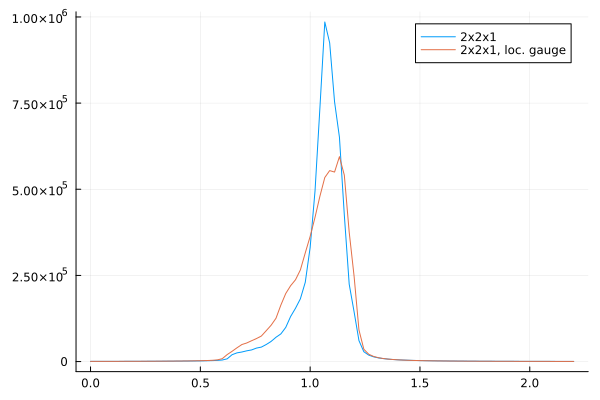

In [22]:


# these curves should be the same
plot()
# plot!(Egrid, real.(res0.Sqω_pm)*4,label="primitive")
plot!(Egrid, real.(res1.Sqω_pm), label="2x2x1")
plot!(Egrid, real.(res2.Sqω_pm), label="2x2x1, loc. gauge")
# plot!(Egrid, real.(res3.Sqω_pm), label="2x2x1, lrge gauge")
# plot!(Egrid, real.(res4.Sqω_pm))

In [23]:
q = SVector{3}(geom.high_symmetry_points["\\Gamma"])
p = SVector{3}(geom.high_symmetry_points["X"])

corr1 = SpinonStructure.corr_at(q,p, csim1)
corr2 = SpinonStructure.corr_at(q, p+shift3, csim1)

([0.7448336594307501 0.7448336594307501 … 0.9846979229891132 0.9846979229891132; 0.7448336594307501 0.7448336594307501 … 0.9846979229891132 0.9846979229891132; … ; 0.9846979229891132 0.9846979229891132 … 1.2245621865474763 1.2245621865474763; 0.9846979229891132 0.9846979229891132 … 1.2245621865474763 1.2245621865474763], ComplexF64[0.0 + 0.0im 18.510670319235068 - 1.124100812432971e-15im … 0.0 + 0.0im -1.3877787807814457e-16 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im -1.3877787807814457e-16 + 0.0im … 0.0 + 0.0im -1.1102230246251565e-16 + 1.5959455978986625e-16im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im], ComplexF64[0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [24]:
eigvals(corr1[1])

8-element Vector{Float64}:
 -0.007712667561967991
 -1.904621534063451e-16
 -9.460090875845799e-33
  7.9490334917073e-51
  4.7607940806516976e-20
  7.955417103322287e-17
  5.990247849429995e-16
  8.943078939748181

In [25]:
eigvals(corr2[1])

8-element Vector{Float64}:
 -0.058802562983814234
 -7.021863680757896e-16
  9.909081287830702e-53
  1.2909340954425503e-35
  5.3805535111566564e-33
  1.7844131942945305e-19
  1.967699942073241e-16
  8.252572607358871